In [1]:
# ===============================================================================================================#
# Copyright 2022 Infosys Ltd.                                                                                    #
# Use of this source code is governed by Apache License Version 2.0 that can be found in the LICENSE file or at  #
# http://www.apache.org/licenses/                                                                                #
# ===============================================================================================================#

## 1. Preparation

In [2]:
import json
from libraries._internal_utils.demo_helper import DemoHelper
import pandas as pd
from IPython.display import Image

#### <span style='color:blue'>Enter image and OCR file paths</span>

In [3]:
IMAGE_PATH="./data/checkbox.jpg"
IMAGE_OCR_PATH='./data/checkbox.hocr'
TEMP_FOLDER_PATH = './data/temp'

#### Visualize

In [4]:
IMAGE_PATHS=[IMAGE_PATH]
tab_widget = DemoHelper.create_tab_toolbar(IMAGE_PATHS)
display(tab_widget)
for idx, image_path in enumerate(IMAGE_PATHS):
    with tab_widget.children[idx]:
        display(Image(filename=image_path, width=800, height=50))

## 2. Initialization

#### <span style='color:blue'>Create new instance with desired OCR service provider</span>

In [ ]:
from infy_field_extractor import checkbox_extractor
from infy_ocr_parser import ocr_parser
from infy_field_extractor.providers.ocr_data_service_provider import OcrDataServiceProvider
from infy_ocr_parser.providers.tesseract_ocr_data_service_provider import TesseractOcrDataServiceProvider
import logging
import os

if not os.path.exists('./logs'):
    os.makedirs('./logs')

if not os.path.exists(TEMP_FOLDER_PATH):
    os.makedirs(TEMP_FOLDER_PATH)    
    
logging.basicConfig(filename=('./logs' + '/app_log.log'),
                format='%(asctime)s- %(levelname)s- %(message)s',
                level=logging.CRITICAL, datefmt='%d-%b-%y %H:%M:%S')
logger = logging.getLogger() 
logger.info('log initialized')
logger = None

# Uncomment below for Tesseract OCR service
data_service_provider = TesseractOcrDataServiceProvider()
# Uncomment below for Azure OCR Read service
# data_service_provider_obj = AzureReadOcrDataServiceProvider()

ocr_parser_object = ocr_parser.OcrParser(ocr_file_list=[IMAGE_OCR_PATH],
                                         data_service_provider=data_service_provider)
provider = OcrDataServiceProvider(ocr_parser_object)

checkbox_obj = checkbox_extractor.CheckboxExtractor(provider,provider,temp_folderpath=TEMP_FOLDER_PATH
                                                    ,logger = logger, debug_mode_check = False)

## 3. API - extract_custom_fields()

### 3.1. Example

In this example "field_key" and "field_state_pos" is required. It searches for the "field_key" in the image using ocr_parser_obj and extracts the state from the nearest checkbox to the "field_key" in the direction given by the param "field_state_pos". If "field_state_pos" not given, it dynamically searches the nearest checkbox in all the direction and extract its state.

In [ ]:
checkbox_field_data_list = [
        {
                "field_key": ["Latin"], 
                "field_state_pos": "left"
        },
        {
                "field_key": ["Esperanto"], 
                "field_state_pos": "left"
        }
]
CONFIG_PARAMS_DICT = {
    "min_checkbox_text_scale": 0.8, 
    "max_checkbox_text_scale": 1.5
}

output = checkbox_obj.extract_custom_fields(image_path = IMAGE_PATH,
        checkbox_field_data_list = checkbox_field_data_list,
        config_params_dict = CONFIG_PARAMS_DICT)

#### Output

In [7]:
df = pd.json_normalize(output['fields'])
print('No. of records found =', len(df))
df

No. of records found = 2


,field_key,field_state,error
0,[Latin],False,None
1,[Esperanto],True,None


#### Visualize

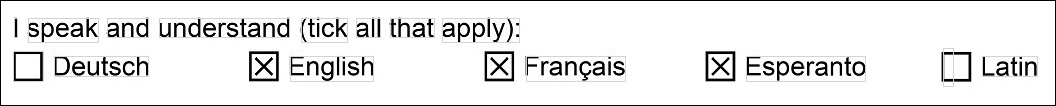

In [8]:
# Get all tokens i.e. without any bounding box restrictions
all_tokens = ocr_parser_object.get_tokens_from_ocr(
    token_type_value=1,     
    pages=[1]
)
all_tokens_text_bboxes = [x['bbox'] for x in all_tokens]

img = DemoHelper.read_image(IMAGE_PATH)
img = DemoHelper.draw_bboxes_on_image(img, all_tokens_text_bboxes, border_thickness=1, 
                                         border_color = DemoHelper.Constants.COLOR_GRAY)

DemoHelper.show_image(img)

### 3.2. Example

In this example "field_state_bbox" is required and "field_key" is optional. For each element in the checkbox_field_data_list, it expects to find one checkbox within the region given by the "field_state_bbox" param and extracts the state of that checkbox.

In [9]:
checkbox_field_data_list = [
    {
        "field_key": [
            "Latin"
        ],
        "field_state_bbox": [
            933,
            45,
            45,
            42
        ]
    },
    {
        "field_key": [
            "Esperanto"
        ],
        "field_state_bbox": [
            699,
            45,
            40,
            42
        ]
    }
]
output = checkbox_obj.extract_custom_fields(image_path = IMAGE_PATH, 
        checkbox_field_data_list = checkbox_field_data_list)

#### Output

In [10]:
df = pd.json_normalize(output['fields'])
print('No. of records found =', len(df))
df

No. of records found = 2


,field_key,field_state_bbox,field_state,error
0,[Latin],"[933, 45, 45, 42]",False,None
1,[Esperanto],"[699, 45, 40, 42]",True,None


#### Visualize

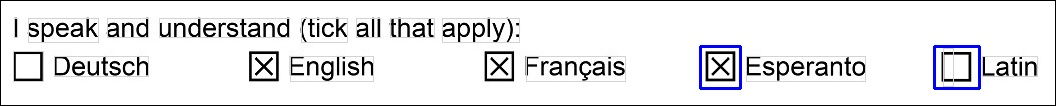

In [11]:
# Get all tokens i.e. without any bounding box restrictions
all_tokens = ocr_parser_object.get_tokens_from_ocr(
    token_type_value=1,     
    pages=[1]
)
all_tokens_text_bboxes = [x['bbox'] for x in all_tokens]

field_state_bboxes = [x['field_state_bbox'] for x in checkbox_field_data_list]
all_bboxes = field_state_bboxes 
img = DemoHelper.read_image(IMAGE_PATH)
img = DemoHelper.draw_bboxes_on_image(img, all_tokens_text_bboxes, border_thickness=1, 
                                         border_color = DemoHelper.Constants.COLOR_GRAY)
img = DemoHelper.draw_bboxes_on_image(img, field_state_bboxes, border_thickness=2,
                                         border_color = DemoHelper.Constants.COLOR_BLUE)
img = DemoHelper.reduce_image_based_on_context(img, all_bboxes)

DemoHelper.show_image(img)

## 4. API - extract_all_fields()

### 4.1 Example

It finds all possible checkboxes and extracts its state and key corresponding to it. The checkbox and the key should be aligned horizontally and not vertically to extract dynamically.

In [ ]:
output = checkbox_obj.extract_all_fields(image_path = IMAGE_PATH)

#### Output

In [13]:
# print(json.dumps(output, indent=4))
df = pd.json_normalize(output['fields']).T
print('No. of records found =', len(df))
df

No. of records found = 5


,0
Latin,False
Esperanto,True
Frangais,True
English,True
Deutsch,False


#### Visualize

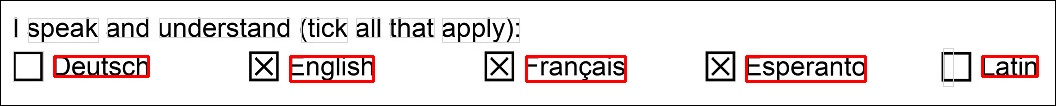

In [14]:
# Get all tokens i.e. without any bounding box restrictions
all_tokens = ocr_parser_object.get_tokens_from_ocr(
    token_type_value=1,     
    pages=[1]
)
all_tokens_text_bboxes = [x['bbox'] for x in all_tokens]

text_bboxes = [x['bbox'] for x in output['fieldsList']]
all_bboxes = text_bboxes 
img = DemoHelper.read_image(IMAGE_PATH)
img = DemoHelper.draw_bboxes_on_image(img, all_tokens_text_bboxes, border_thickness=1, 
                                         border_color = DemoHelper.Constants.COLOR_GRAY)
img = DemoHelper.draw_bboxes_on_image(img, text_bboxes, border_thickness=2,
                                         border_color = DemoHelper.Constants.COLOR_RED)
img = DemoHelper.reduce_image_based_on_context(img, all_bboxes)

DemoHelper.show_image(img)